# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [2]:
# If running in Google Colab, you can install optional packages here:
!pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 105.0 MB/s eta 0:00:00


## 1) Dataset Setup & Quick Audit

In [3]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [5]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [6]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [7]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [8]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [9]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

In [10]:
# Comparing Mean and Median

import pandas as pd

# Assuming your dataset is loaded as df
# Example: df = pd.read_csv("titanic.csv")

# Check missing values
print("Missing in Age:", df['Age'].isna().sum())

# Mean imputation
df_mean_imputed = df.copy()
df_mean_imputed['Age'] = df_mean_imputed['Age'].fillna(df['Age'].mean())

# Median imputation
df_median_imputed = df.copy()
df_median_imputed['Age'] = df_median_imputed['Age'].fillna(df['Age'].median())

# Compare distributions
print("Original Age distribution:\n", df['Age'].describe())
print("\nAfter Mean Imputation:\n", df_mean_imputed['Age'].describe())
print("\nAfter Median Imputation:\n", df_median_imputed['Age'].describe())


Missing in Age: 177
Original Age distribution:
 count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

After Mean Imputation:
 count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

After Median Imputation:
 count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64


In [11]:
# Check missing values in Embarked
print("Missing in Embarked:", df['Embarked'].isna().sum())

# Mode imputation
df_mode_imputed = df.copy()
mode_value = df['Embarked'].mode()[0]
df_mode_imputed['Embarked'] = df_mode_imputed['Embarked'].fillna(mode_value)

print("\nValue counts after Mode Imputation:")
print(df_mode_imputed['Embarked'].value_counts())

# 'Unknown' imputation
df_unknown_imputed = df.copy()
df_unknown_imputed['Embarked'] = df_unknown_imputed['Embarked'].fillna('Unknown')

print("\nValue counts after 'Unknown' Imputation:")
print(df_unknown_imputed['Embarked'].value_counts())


Missing in Embarked: 2

Value counts after Mode Imputation:
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

Value counts after 'Unknown' Imputation:
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

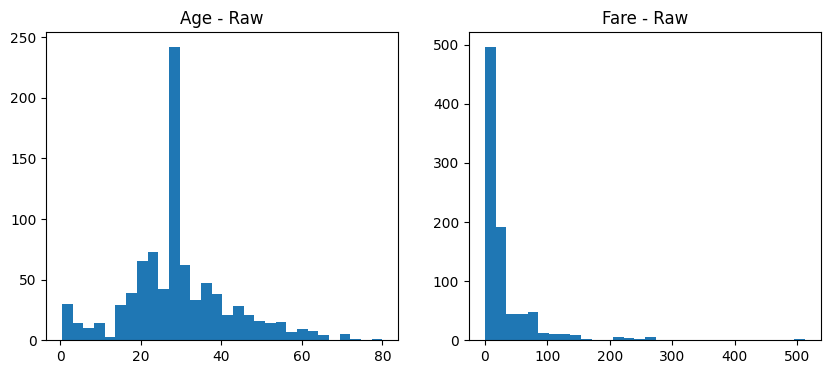

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

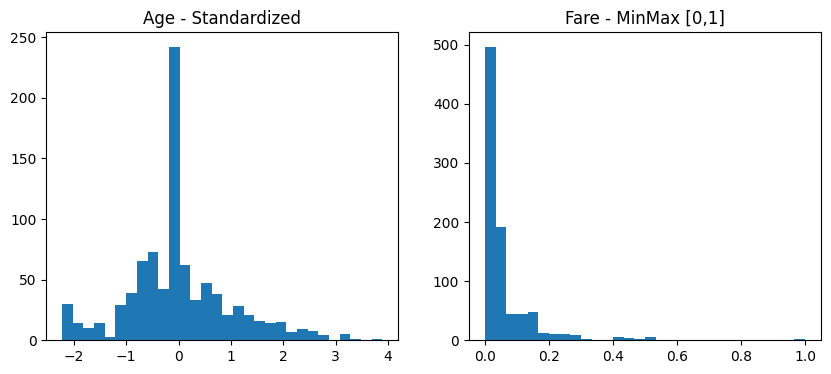

In [13]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

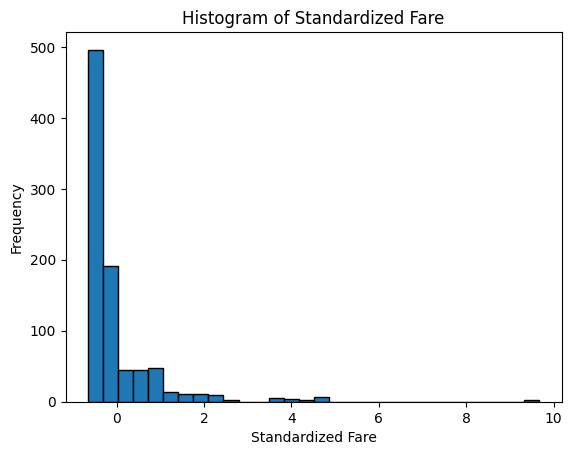

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize Fare
scaler = StandardScaler()
df['Fare_standardized'] = scaler.fit_transform(df[['Fare']])

# Plot histogram
plt.hist(df['Fare_standardized'], bins=30, edgecolor='black')
plt.title("Histogram of Standardized Fare")
plt.xlabel("Standardized Fare")
plt.ylabel("Frequency")
plt.show()


In [15]:
from sklearn.preprocessing import Normalizer

# Select Age and Fare
age_fare = df[['Age', 'Fare']].dropna()   # remove NaNs before normalizing

# Apply Normalizer (L2 norm by default)
normalizer = Normalizer()
age_fare_normalized = normalizer.fit_transform(age_fare)

# Check first 5 normalized vectors
print("First 5 normalized [Age, Fare] rows:")
print(age_fare_normalized[:5])


First 5 normalized [Age, Fare] rows:
[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [16]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [17]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

1) Compare the number of features produced by ordinal vs one-hot for Embarked.


Suppose your Embarked column has 3 categories:

Embarked = ['S', 'C', 'Q']


Ordinal Encoding

Assign integers (e.g., S=0, C=1, Q=2).

Produces 1 feature column.

Example:

Embarked_ordinal
----------------
0
1
2


One-Hot Encoding

Creates one binary column per category.

Produces 3 feature columns (S, C, Q).

Example:

Embarked_S  Embarked_C  Embarked_Q
---------   ----------  ----------
1           0           0
0           1           0
0           0           1


✅ So:

Ordinal → 1 feature

One-hot → N features (equal to number of categories)

2) Why might one-hot be safer for linear models?

In ordinal encoding, categories are represented as integers (0,1,2,…).

Linear models may mistakenly assume an order/scale (e.g., “Q > C > S”), even if categories have no natural order.

This can distort relationships and bias coefficients.

In one-hot encoding, each category gets its own binary feature.

No false ordering is imposed.

The model treats each category independently.

Safer for linear models (like Logistic Regression, Linear Regression), because coefficients represent the effect of belonging to a category vs not.

## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

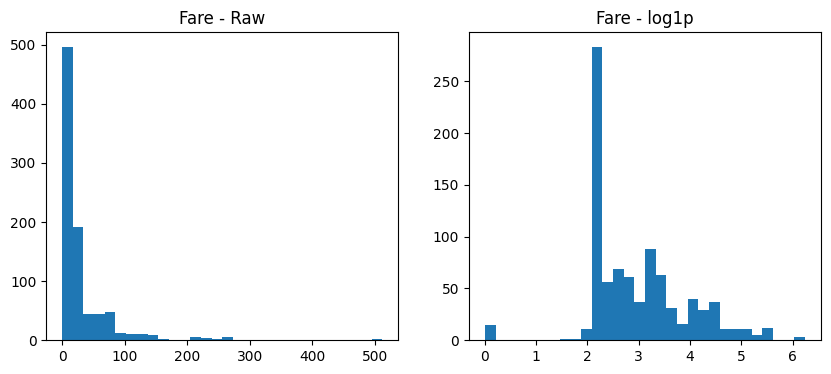

In [18]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

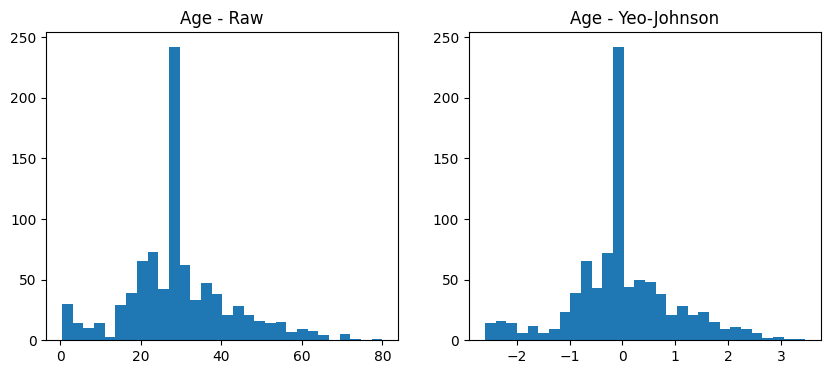

In [19]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [20]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

Age     0.389108
Fare    4.787317
dtype: float64


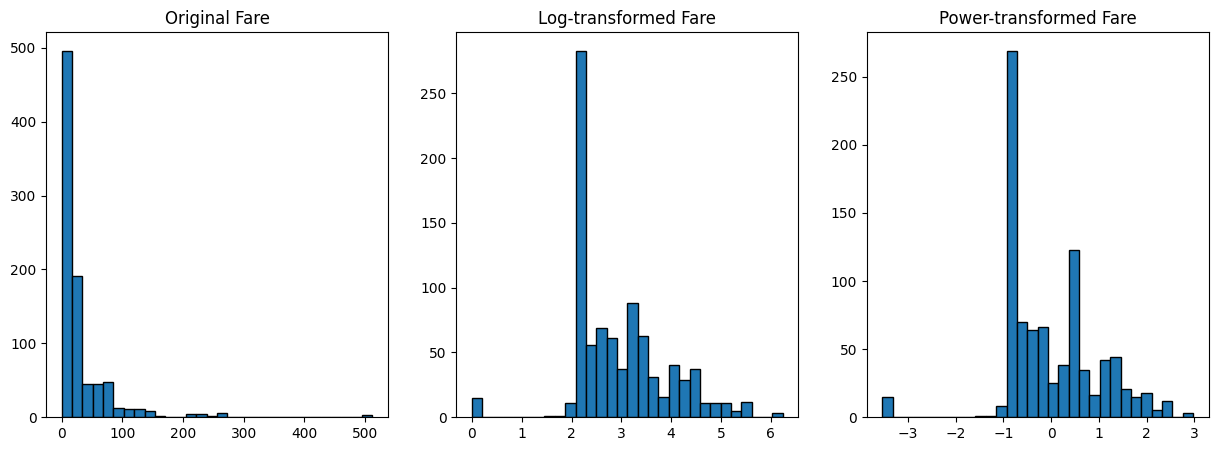

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Check skewness of numeric columns
print(df[['Age', 'Fare']].skew())

# Use Fare (skewed column)
fare = df['Fare'].dropna()

# Log transform (add 1 to avoid log(0))
fare_log = np.log1p(fare)

# Power transform (Yeo-Johnson handles zeros & negatives)
pt = PowerTransformer(method='yeo-johnson')
fare_power = pt.fit_transform(fare.values.reshape(-1, 1)).flatten()

# Plot histograms
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(fare, bins=30, edgecolor='black')
plt.title("Original Fare")

plt.subplot(1,3,2)
plt.hist(fare_log, bins=30, edgecolor='black')
plt.title("Log-transformed Fare")

plt.subplot(1,3,3)
plt.hist(fare_power, bins=30, edgecolor='black')
plt.title("Power-transformed Fare")

plt.show()


In [22]:
from sklearn.preprocessing import PolynomialFeatures

X = df[['Age', 'Fare']].dropna()

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

print("Feature names:", poly.get_feature_names_out(['Age', 'Fare']))


Feature names: ['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']


## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


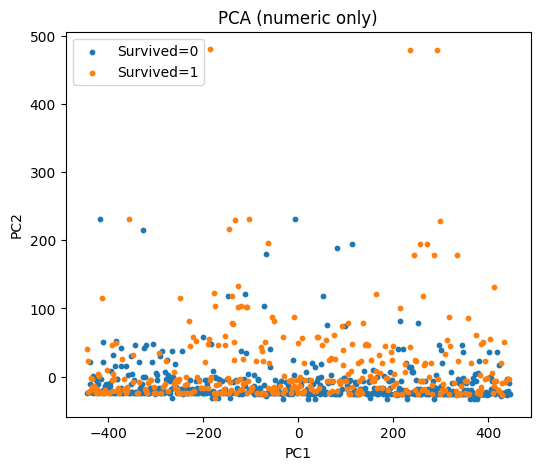

In [23]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [24]:
# Variance of numeric columns
numeric_var = df.select_dtypes(include=[np.number]).var().sort_values(ascending=False)
print("Variance of numeric columns:\n", numeric_var)

# Top 2 columns with highest variance
top2 = numeric_var.head(2)
print("\nTop 2 columns contributing most variance:\n", top2)


Variance of numeric columns:
 PassengerId          66231.000000
Fare                  2469.436846
Age                    211.019125
SibSp                    1.216043
Fare_standardized        1.001124
Pclass                   0.699015
Parch                    0.649728
Survived                 0.236772
dtype: float64

Top 2 columns contributing most variance:
 PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numeric columns and drop NA
X_num = df.select_dtypes(include=[np.number]).dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

# PCA with 3 components
pca = PCA(n_components=3)
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained variance ratio (3 components):", explained_variance)
print("Cumulative explained variance:", cumulative_variance)


Explained variance ratio (3 components): [0.33452145 0.21190635 0.12606491]
Cumulative explained variance: [0.33452145 0.5464278  0.67249271]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming Titanic dataset is in df

# --- Step 1: Impute ---
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Cabin'] = df['Cabin'].fillna('Unknown')

# --- Step 2: Scale ---
# Standardize Age
scaler_age = StandardScaler()
df['Age_standardized'] = scaler_age.fit_transform(df[['Age']])

# Min-Max scale Fare
scaler_fare = MinMaxScaler()
df['Fare_minmax'] = scaler_fare.fit_transform(df[['Fare']])

# --- Step 3: Encode ---
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid dummy trap
encoded = encoder.fit_transform(df[['Sex', 'Embarked']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Sex','Embarked']))

df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# --- Step 4: Transform ---
df['Fare_log1p'] = np.log1p(df['Fare'])

# --- Step 5: Optional PCA ---
numeric_cols = df.select_dtypes(include=[np.number]).dropna(axis=1).columns
X_num = df[numeric_cols]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_num)


2) Questions
🔹 Which step changed the data distribution the most?

Log1p transformation of Fare changed the distribution the most, because Fare is highly skewed.

Scaling (standardization, min-max) changes the scale but not the shape of the distribution.

Imputation and encoding don’t affect distribution as much.

✅ Answer: Log1p on Fare.

🔹 Which encoding produced more features, ordinal or one-hot? Why?

Ordinal encoding → produces 1 column regardless of categories.

One-hot encoding → produces N columns (equal to the number of categories, minus 1 if drop-first).

One-hot produces more features because it represents each category separately, avoiding false ordering.

✅ Answer: One-hot produced more features because it expands categories into separate binary features.


In [28]:
# Prepare data (use Survived as target if Titanic dataset)
X = df[['Age_standardized', 'Fare_minmax', 'Fare_log1p'] + list(encoded_df.columns)]
y = df['Survived']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Accuracy
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)


Logistic Regression Accuracy: 0.7757847533632287


## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).